In [14]:
import sys
from pathlib import Path

# Get the current notebook's directory
parent = Path().resolve()  # Current working directory (notebook's directory)
root = parent.parent.parent       # Go one level up

print("Current Directory:", parent)
print("Parent Directory:", root)

# Optionally append to sys.path
sys.path.append(str(root))


Current Directory: C:\Users\Jake\Learning-Dynamic-Systems\search\notebooks
Parent Directory: C:\Users\Jake\Learning-Dynamic-Systems


In [15]:
pip install redis[hiredis]

Note: you may need to restart the kernel to use updated packages.


## Initialise ARMAX System and Generate Data

In [16]:
from indirect_identification.armax import ARMAX
from indirect_identification.d_tfs import d_tfs
import numpy as np
from scipy import signal, optimize
# y(t) = -ay(t-1) + bu(t-1) + e(t)

# True parameters
a1_true = 0.2
b1_true = 0.8

A = [1, a1_true]
B = [b1_true]
C = [1]
F = [0]
L = [1]

n_samples = 100

# Initialise the system
armax_model = ARMAX(A, B, C, F, L)
R = signal.square(np.linspace(0, 10*np.pi, n_samples))
Y, U, N, R = armax_model.simulate(n_samples, R, noise_std=1)

# Least squares estimate using scipy


## Least Squares callback

In [18]:
from indirect_identification.d_tfs import d_tfs
import numpy as np

is_verbose = False
# Least squares function
def test_ls(params, U, Y):
    """
        params: vector of parameters to test
        K:      gain of the controller for this test run. Currently assumed to be constant
        U: U_t signal
        Y: Y_t signal
    """
    if is_verbose:
        print(f"Calculating loss with params {params}")
        [print(f"Number of inputs: {len(U)}")]
        [print(f"Number of outputs: {len(Y)}")]
    a, b = params


    A = [1, a]
    B = [0, b]
    C = [1]

    G = d_tfs((B, A))
    H = d_tfs((C,A))

    YGU = Y - G * U
    N_hat = (1/H) * YGU

    ret_val = np.sum([N_hat**2])  # Return SSE
    if is_verbose:
        print(ret_val)
    return ret_val

## Calculate the LSE

In [19]:

x0 = np.array([0, 0]) # Initial estimates
res = optimize.least_squares(test_ls, x0, args=(U, Y))
params_ls = res.x



print(params_ls)
# armax_model.plot_results(Y, U, N, R)

[0.21783001 0.902421  ]


## Initialise the SPS Model and Search Callback

In [17]:
# Initialise SPS 
from indirect_identification.sps_indirect import SPS_indirect_model
n_samples = 50

m = 100
q = 5

model = SPS_indirect_model(m, q)

def sps_test_function(params, U, Y):
    print("Testing", params)
    a, b = params
    A = [1, a]
    B = [0, b]
    C = [1]

    G = (B, A)  # G should be a tuple of arrays
    H = (C, A)  # H should be a tuple of arrays


    # Check the condition and store the result if true
    in_sps, S1 = model.open_loop_sps(G, H, Y, U, 1, 1)  # Assuming Y and U are defined
    return in_sps



### Generate Unit Vectors

[array([0, 1]), array([1, 0]), array([-0.07939616,  0.99684314]), array([0.50130765, 0.86526911]), array([-0.90044829,  0.43496307]), array([ 0.02247519, -0.9997474 ]), array([-0.30256965, -0.95312728]), array([-0.56343894, -0.82615771]), array([ 0.61132748, -0.79137773]), array([-0.93927151, -0.34317494]), array([ 0.61478639, -0.78869366]), array([-0.83990694,  0.54273045])]


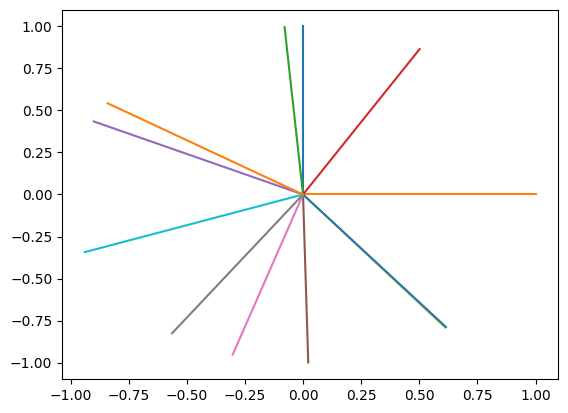

In [78]:
n_dim = 2
n_random_vectors = 10

vectors = []

# Generate Basis Vectors
v1 = np.array([0,1])
v2 = np.array([1,0])

vectors.extend([v1, v2])

for _ in range(n_random_vectors):
    rand_vec = np.random.uniform(-1, 1) * v1 + np.random.uniform(-1, 1) * v2 # Create random linear combination of basis vectors
    rand_vec /= np.linalg.norm(rand_vec)
    vectors.extend(np.array([rand_vec]))

print(vectors)
vectors = np.array(vectors)

# Plot the vectors
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

for i in range(len(vectors)):
    ax.plot([0, vectors[i, 0]], [0, vectors[i, 1]])


## Plot the Results

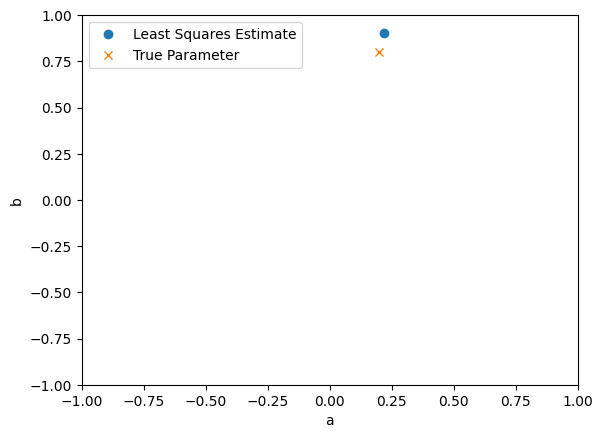

In [22]:
# Plot results
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ls_a, ls_b = params_ls
ax.plot(ls_a, ls_b, 'o', label="Least Squares Estimate")
ax.plot(a1_true, b1_true, 'x', label="True Parameter")
ax.legend()
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel("a")
ax.set_ylabel("b")

plt.show()